**任务描述：Phoneme Classification 这是一个41分类的问题，这个作业给的是LibriSpeech 的一个子数据集**
 
 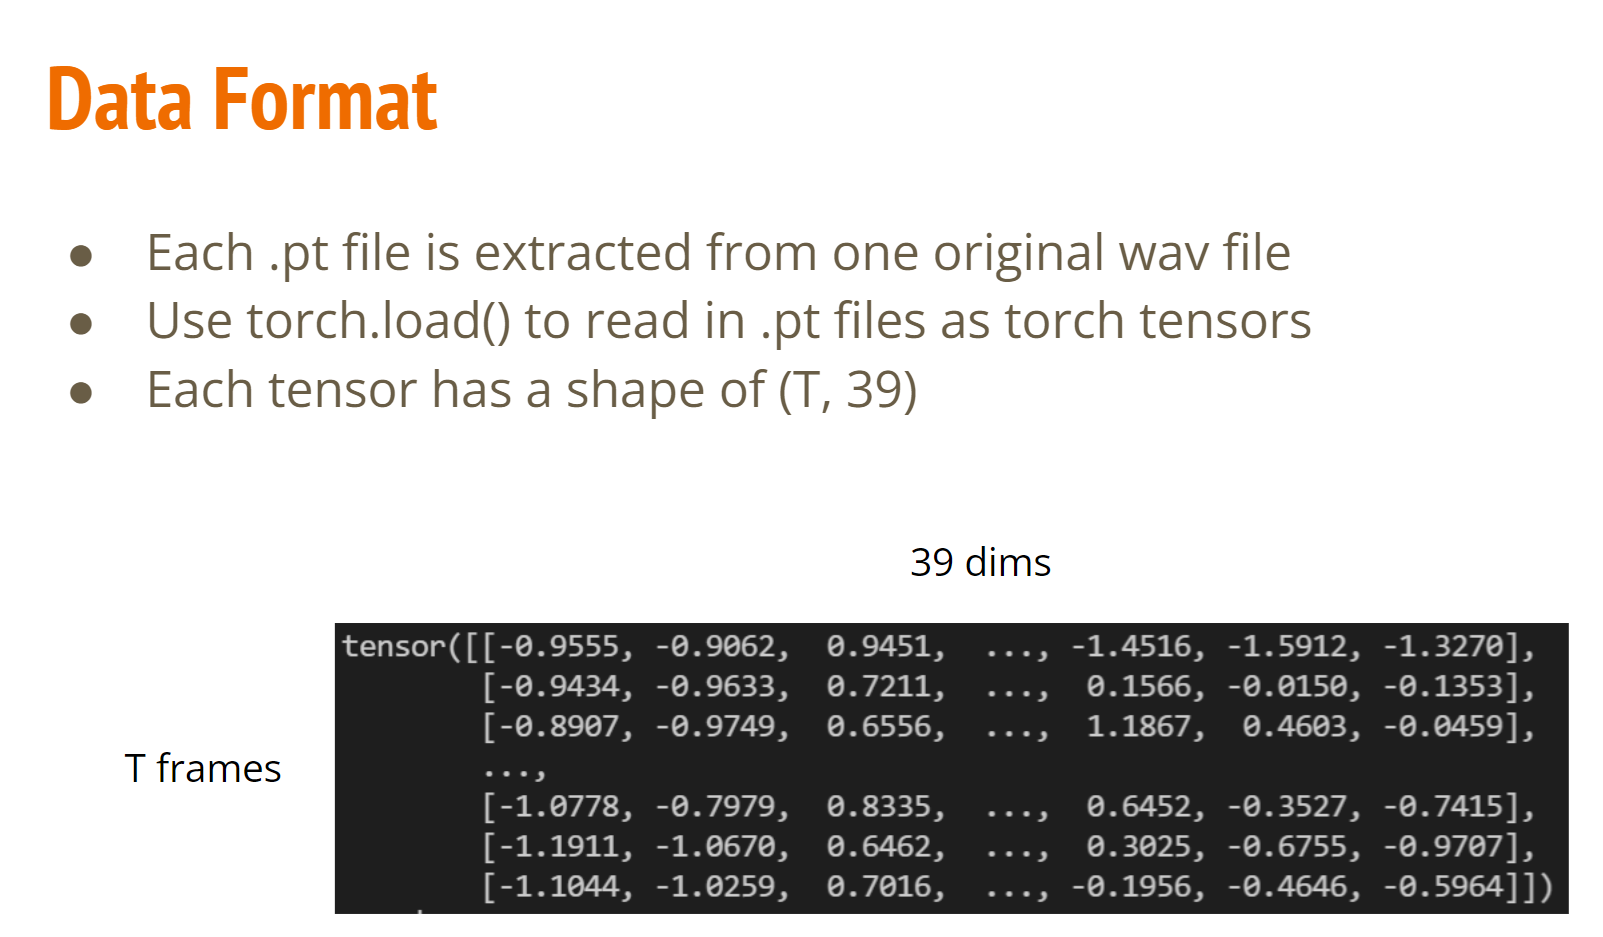
 
 **Homework 2 Phoneme Classification**

* Slides: https://docs.google.com/presentation/d/1v6HkBWiJb8WNDcJ9_-2kwVstxUWml87b9CnA16Gdoio/edit?usp=sharing
* Kaggle: https://www.kaggle.com/c/ml2022spring-hw2
* Video: TBA


In [1]:
# !nvidia-smi ## 要开启GPU

/bin/bash: nvidia-smi: command not found


## Download Data
Download data from google drive, then unzip it.

You should have
- `libriphone/train_split.txt`
- `libriphone/train_labels`
- `libriphone/test_split.txt`
- `libriphone/feat/train/*.pt`: training feature<br>
- `libriphone/feat/test/*.pt`:  testing feature<br>

after running the following block.

> **Notes: if the google drive link is dead, you can download the data directly from [Kaggle](https://www.kaggle.com/c/ml2022spring-hw2/data) and upload it to the workspace**


### Download train/test metadata

In [1]:
!pip install --upgrade gdown

# Main link
!gdown --id '1o6Ag-G3qItSmYhTheX6DYiuyNzWyHyTc' --output libriphone.zip

# Backup link 1
# !gdown --id '1R1uQYi4QpX0tBfUWt2mbZcncdBsJkxeW' --output libriphone.zip

# Bqckup link 2
# !wget -O libriphone.zip "https://www.dropbox.com/s/wqww8c5dbrl2ka9/libriphone.zip?dl=1"

!unzip -q libriphone.zip
!ls libriphone

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1o6Ag-G3qItSmYhTheX6DYiuyNzWyHyTc
To: /kaggle/working/libriphone.zip
100%|████████████████████████████████████████| 479M/479M [00:07<00:00, 63.9MB/s]
feat  test_split.txt  train_labels.txt	train_split.txt


### Preparing Data

**Helper functions to pre-process the training data from raw MFCC features of each utterance.**

A phoneme may span several frames and is dependent to past and future frames. \
Hence we concatenate neighboring phonemes for training to achieve higher accuracy. The **concat_feat** function concatenates past and future k frames (total 2k+1 = n frames), and we predict the center frame.

Feel free to modify the data preprocess functions, but **do not drop any frame** (if you modify the functions, remember to check that the number of frames are the same as mentioned in the slides)

In [46]:
# load_feat('/kaggle/input/ml2022spring-hw2/libriphone/libriphone/feat/train/2007-149877-0023.pt').shape

torch.Size([500, 39])

In [ ]:
# load_feat('/kaggle/input/ml2022spring-hw2/libriphone/libriphone/feat/train/8465-246942-0027.pt').shape

In [4]:
# len(load_feat('/kaggle/input/ml2022spring-hw2/libriphone/libriphone/feat/train/103-1240-0006.pt'))

In [61]:
import os
import random
import pandas as pd
import torch
from tqdm import tqdm

# 函数加载特征。
def load_feat(path):
    """
    加载特征
    Args:
        path: 特征文件路径
    Returns:
        feat: 特征
    """
    feat = torch.load(path)
    return feat

# 将特征x平移n帧。
# 假设preprocess_data传入concat_feat的一个 feat 的 shape 为 torch.Size([936, 39]) ，经过concat_nframes=5的拼接，
# 首先会在feat的外面扩展一个维度，在里面生成5个feat，对应的代码：x = x.repeat(1, concat_n) 
# 然后permute，再进行shift的操作，shift完之后 concat_feat 在进行一次x.permute和view，最后形状变为 torch.Size([936, 195])
# 其实就是在原先feat的基础上，对每一行的特征进行和n有关的扩展（shift函数），在每一行的特征中加入上几行或者下几行的特征

def shift(x, n):

    if n < 0:
        left = x[0].repeat(-n, 1) ## 将第一行特征在1维上重复生产n次
        right = x[:n]             ## right等于x从前面到索引为n，加入n=2，那么left就是两个x[0]组合而成的，right就是从0开始到倒数第二个元素
                                  ## 拼接返回之后concat_feat经过view，最后可以得到每一行的特征引入了前面和后面若干行的特征。

    elif n > 0:
        right = x[-1].repeat(n, 1)
        left = x[n:]
    else:
        return x
#     print("left: ",left,left.shape)
#     print("right: ",right,right.shape)
#     print("torch.cat: ",torch.cat((left, right), dim=0),torch.cat((left, right), dim=0).shape)
    return torch.cat((left, right), dim=0)

# 将特征x拼接n个帧，返回concat_n * feature_dim大小的特征。
def concat_feat(x, concat_n):

    assert concat_n % 2 == 1 # n must be odd
    if concat_n < 2:
        return x
    seq_len, feature_dim = x.size(0), x.size(1)
    # 在维度为1的情况下，对x进行横向为concat_n倍的扩展
    x = x.repeat(1, concat_n) 
#     print("x view before:",x,x.shape)
    x = x.view(seq_len, concat_n, feature_dim).permute(1, 0, 2) # concat_n, seq_len, feature_dim
#     print("x after:",x,x.shape)

    mid = (concat_n // 2)
    for r_idx in range(1, mid+1):
        # 索引为 mid的列表不变，mid索引前后的列表进行shift操作
        x[mid + r_idx, :] = shift(x[mid + r_idx], r_idx) 
        x[mid - r_idx, :] = shift(x[mid - r_idx], -r_idx)

    return x.permute(1, 0, 2).view(seq_len, concat_n * feature_dim) # permute seq_len,concat_n,feature_dim 

# 根据指定的split，从feat_dir文件夹中加载特征，并将其分离为训练集和测试集，然后将特征进行拼接变换，最后返回转化后的特征。
def preprocess_data(split, feat_dir, phone_path, concat_nframes, train_ratio=0.8, train_val_seed=1337):
    """
    根据指定的split，从feat_dir文件夹中加载特征，并将其分离为训练集和测试集，然后将特征进行拼接变换，最后返回转化后的特征
    Args:
        split: 数据集的划分，可以为'train'，'val'或'test'
        feat_dir: 特征文件夹的路径
        phone_path: phone文件夹的路径
        concat_nframes: 要拼接的帧数
        train_ratio: 训练集所占比例，默认为0.8
        train_val_seed: 训练集和验证集的随机种子，默认为1337
    Returns:
        X: 转化后的特征
        y: 验证集或测试集的标签
    """
    class_num = 41 # NOTE: pre-computed, should not need change
    mode = 'train' if (split == 'train' or split == 'val') else 'test'

    label_dict = {}
    if mode != 'test':
        phone_file = open(os.path.join(phone_path, f'{mode}_labels.txt')).readlines()
        ## 需要对数据进行去空值处理，label的个数和feat的长度一致
        for line in phone_file:
            line = line.strip('\n').split(' ')
            label_dict[line[0]] = [int(p) for p in line[1:]]
#         return label_dict

    if split == 'train' or split == 'val':
        # split training and validation data
        usage_list = open(os.path.join(phone_path, 'train_split.txt')).readlines()
        random.seed(train_val_seed)
        random.shuffle(usage_list)
        percent = int(len(usage_list) * train_ratio)
        usage_list = usage_list[:percent] if split == 'train' else usage_list[percent:]
    elif split == 'test':
        usage_list = open(os.path.join(phone_path, 'test_split.txt')).readlines()
    else:
        raise ValueError('Invalid \'split\' argument for dataset: PhoneDataset!')

    usage_list = [line.strip('\n') for line in usage_list]
#     return usage_list
    print('[Dataset] - # phone classes: ' + str(class_num) + ', number of utterances for ' + split + ': ' + str(len(usage_list)))

    max_len = 3000000
    X = torch.empty(max_len, 39 * concat_nframes)
    if mode != 'test':
        y = torch.empty(max_len, dtype=torch.long)

    idx = 0
    for i, fname in tqdm(enumerate(usage_list)):
        feat = load_feat(os.path.join(feat_dir, mode, f'{fname}.pt'))
        cur_len = len(feat)
#         print('feat before : ',feat)
#         return feat

        feat = concat_feat(feat, concat_nframes) 
        if mode != 'test':
            label = torch.LongTensor(label_dict[fname])
#         print('feat after : ',feat)
#         return feat,fname

        X[idx: idx + cur_len, :] = feat   ## X[0:3000000,:] 有3000000行
        if mode != 'test':
            y[idx: idx + cur_len] = label

        idx += cur_len ## 加入每一个feat记录一下当前行数
    
    print(idx)
    X = X[:idx, :] ## 原先设置为max_len 长度的X改为现有长度
    if mode != 'test':
        y = y[:idx]

    print(f'[INFO] {split} set')
    print(X.shape)
    if mode != 'test':
        print(y.shape)
        return X, y
    else:
        return X

## Define Dataset

In [50]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LibriDataset(Dataset):
    """
    根据输入的X和y，创建DataLoader
    Args:
        X: 特征
        y: 标签
        batch_size: batch大小
        shuffle: 是否需要打乱数据
    Returns:
        data_loader: DataLoader
    """
    def __init__(self, X, y=None):
        self.data = X
        if y is not None:
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


## Define Model

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module): 
    def __init__(self, input_dim, output_dim):
        super(BasicBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.block(x)
        return x


class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim=41, hidden_layers=1, hidden_dim=256):
        super(Classifier, self).__init__()

        self.fc = nn.Sequential(
            BasicBlock(input_dim, hidden_dim),
            *[BasicBlock(hidden_dim, hidden_dim) for _ in range(hidden_layers)],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

## Hyper-parameters

In [64]:
# data prarameters
concat_nframes =3              # the number of frames to concat with, n must be odd (total 2k+1 = n frames)
train_ratio = 0.8               # the ratio of data used for training, the rest will be used for validation

# training parameters
seed = 0                        # random seed
batch_size = 512                # batch size
num_epoch = 5                   # the number of training epoch
learning_rate = 0.0001          # learning rate
model_path = './model.ckpt'     # the path where the checkpoint will be saved

# model parameters
input_dim = 39 * concat_nframes # the input dim of the model, you should not change the value
hidden_layers = 1               # the number of hidden layers
hidden_dim = 256                # the hidden dim

## Prepare dataset and model

In [65]:
import gc

# preprocess data
train_X, train_y = preprocess_data(split='train', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes, train_ratio=train_ratio)
val_X, val_y = preprocess_data(split='val', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes, train_ratio=train_ratio)

# get dataset
train_set = LibriDataset(train_X, train_y)
val_set = LibriDataset(val_X, val_y)

# remove raw feature to save memory
# del train_X, train_y, val_X, val_y
# gc.collect()

# get dataloader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

[Dataset] - # phone classes: 41, number of utterances for train: 3428


3428it [00:02, 1208.25it/s]


2116368
[INFO] train set
torch.Size([2116368, 117])
torch.Size([2116368])
[Dataset] - # phone classes: 41, number of utterances for val: 858


858it [00:00, 1136.60it/s]


527790
[INFO] val set
torch.Size([527790, 117])
torch.Size([527790])


In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

DEVICE: cpu


In [11]:
import numpy as np

#fix seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [12]:
# fix random seed
same_seeds(seed)

# create model, define a loss function, and optimizer
model = Classifier(input_dim=input_dim, hidden_layers=hidden_layers, hidden_dim=hidden_dim).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

## Training

In [13]:
best_acc = 0.0
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    # training
    model.train() # set the model to training mode
    for i, batch in enumerate(tqdm(train_loader)):
        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() 
        outputs = model(features) 
        
            loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step() 
        
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        train_acc += (train_pred.detach() == labels.detach()).sum().item()
        train_loss += loss.item()
    
    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_loader)):
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features)
                
                loss = criterion(outputs, labels) 
                
                _, val_pred = torch.max(outputs, 1) 
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')


100%|██████████| 1031/1031 [00:04<00:00, 207.94it/s]


[001/005] Train Acc: 0.454782 Loss: 1.939118 | Val Acc: 0.483988 loss: 1.790828
saving model with acc 0.484


100%|██████████| 1031/1031 [00:04<00:00, 208.89it/s]


[002/005] Train Acc: 0.497477 Loss: 1.732517 | Val Acc: 0.501538 loss: 1.712800
saving model with acc 0.502


100%|██████████| 1031/1031 [00:04<00:00, 207.48it/s]


[003/005] Train Acc: 0.510961 Loss: 1.673413 | Val Acc: 0.510624 loss: 1.670100
saving model with acc 0.511


100%|██████████| 1031/1031 [00:05<00:00, 193.89it/s]


[004/005] Train Acc: 0.519839 Loss: 1.635128 | Val Acc: 0.518098 loss: 1.639644
saving model with acc 0.518


100%|██████████| 1031/1031 [00:04<00:00, 207.35it/s]

[005/005] Train Acc: 0.526332 Loss: 1.607434 | Val Acc: 0.523479 loss: 1.617581
saving model with acc 0.523


In [11]:
del train_loader, val_loader
gc.collect()

0

## Testing
Create a testing dataset, and load model from the saved checkpoint.

In [14]:
# load data
test_X = preprocess_data(split='test', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes)
test_set = LibriDataset(test_X, None)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

[Dataset] - # phone classes: 41, number of utterances for test: 1078


1078it [00:00, 1235.60it/s]

[INFO] test set
torch.Size([646268, 117])


In [15]:
# load model
model = Classifier(input_dim=input_dim, hidden_layers=hidden_layers, hidden_dim=hidden_dim).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Make prediction.

In [16]:
test_acc = 0.0
test_lengths = 0
pred = np.array([], dtype=np.int32)

model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        features = batch
        features = features.to(device)

        outputs = model(features)

        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        pred = np.concatenate((pred, test_pred.cpu().numpy()), axis=0)


100%|██████████| 1263/1263 [00:04<00:00, 277.70it/s]


Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [17]:
with open('prediction.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(pred):
        f.write('{},{}\n'.format(i, y))